In [9]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def criaDatasetBidimensionalNãoLinearmenteSeparável(n=20, n_classes=3):
    """
    Cria um dataset bidimensional multiclasse não linearmente separável.
    """
    X, y = make_blobs(n_samples=n, centers=n_classes*2, cluster_std=0.8)
    y = np.array(y%n_classes, dtype=int)
    return X, y

X, y = criaDatasetBidimensionalNãoLinearmenteSeparável(1000)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

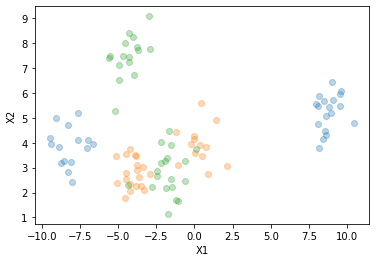

In [10]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

In [11]:
def define_axes(X):
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-.1, max1+.1, min2-.1, max2+.1]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [12]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [13]:
def define_axes(X):
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-.1, max1+.1, min2-.1, max2+.1]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [14]:
from scipy.special import expit

def tanh(a):
    return expit(a)*2-1

In [15]:
def includebias(X):
    bias = np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X), axis=1)
    return Xb

class Backpropagation():
    def __init__(self, n_hidden=5):
        self.n_hidden = n_hidden
        self.activation = tanh
        self.learning_rate = 0.005
        self.max_iter = 1000
    
    def forward(self):
        self.pH = self.Xb @ self.ihw
        self.H = self.activation(self.pH)
        self.Hb = includebias(self.H)
        self.py = self.Hb @ self.how

    def backward(self, y):
        ho_delta = y - self.py
        ho_grad = self.Hb.T @ ho_delta
        ### PULO DO GATO ###
        tanh_grad = (1 - np.square(self.H)) # (1 - np.square(tanh(self.pH)))
        ih_delta = (ho_delta @ self.how[1:,:].T) * tanh_grad
        ### ### ###
        ih_grad = self.Xb.T @ ih_delta
        self.how += ho_grad * self.learning_rate
        self.ihw += ih_grad * self.learning_rate
    
    def fit(self, X, y):
        self.Xb = includebias(X)
        self.ihw = np.random.uniform(-1, 1, size=(self.Xb.shape[1], self.n_hidden))
        self.how = np.random.uniform(-1, 1, size=(self.n_hidden+1, y.shape[1]))
        for _ in range(self.max_iter):
            self.forward()
            self.backward(y)
    
    def predict(self, X):
        Xb = includebias(X)
        H = self.activation(Xb @ self.ihw)
        Hb = includebias(H)
        return Hb @ self.how

0.93
0.9188888888888889
[[  1.05224314   1.51064773 -10.4885375    3.42865095   0.76982621]
 [ -2.549418    -2.38933174  -2.14796505   4.10085326  -1.37395397]
 [ -0.76426663   2.38449359  -0.52192385   3.28545704   1.32549827]]
[[ 1.05435117 -1.06605927 -0.9833964 ]
 [ 0.01772809 -1.02204129  1.00923886]
 [-0.27435284  0.56244138  0.00741611]
 [ 1.07999248 -1.01120327 -0.06867524]
 [ 0.05138164 -1.01646623  0.96518617]
 [-0.72418128  0.36876841  0.05024911]]


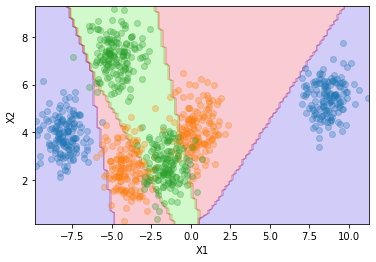

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

class MLP(BaseEstimator, ClassifierMixin):
    """
    Versão do MLP multiclasse que com duas camadas.
    """
    def __init__(self, training_algorithm=Backpropagation()):
        self.training_algorithm = training_algorithm

    def encode_labels(self, y):
        self.labels = list(set(y))
        return label_binarize(y, classes=self.labels)*2-1

    def fit(self, X, y):
        yhot = self.encode_labels(y)
        self.training_algorithm.fit(X, yhot)

    def predict(self, X):
        a = self.training_algorithm.predict(X)
        if len(self.labels) <= 2:
            idx = np.array(a > 0, dtype=int).reshape((-1,))
        else:
            idx = np.argmax(a, axis=1) 
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

mlp = MLP()
mlp.fit(Xtr, ytr)
print(accuracy(ytr, mlp.predict(Xtr)))
print(accuracy(yte, mlp.predict(Xte)))
plotaDatasetBidimensional(Xte, yte)
plot_predictions(mlp, Xte)
print(mlp.training_algorithm.ihw)
print(mlp.training_algorithm.how)